<a href="https://www.kaggle.com/eileends/jigsaw-model-selection?scriptVersionId=86231327" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [9]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from bs4 import BeautifulSoup
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re 
import scipy
from scipy import sparse
from IPython.display import display
from pprint import pprint
from matplotlib import pyplot as plt 
import time
import scipy.optimize as optimize
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from sklearn.linear_model import Ridge
import zipfile
import string
import nltk
import string
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer() 

In [10]:
!pip install seaborn==0.11.0

data collecting

In [11]:
# train_csv_zip_path = '../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip'
# with zipfile.ZipFile(train_csv_zip_path) as zf:
#     zf.extractall('./')


In [12]:
# train_csv_path = '../input/d/julian3833/jigsaw-toxic-comment-classification-challenge/train.csv'
# sample_sub_path = '../input/jigsaw-toxic-severity-rating/sample_submission.csv'
# comments_to_score_path = '../input/jigsaw-toxic-severity-rating/comments_to_score.csv'
# val_path='../input/jigsaw-toxic-severity-rating/validation_data.csv'

In [13]:
df_train = pd.read_csv("../input/d/julian3833/jigsaw-toxic-comment-classification-challenge/train.csv")
df_sub = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")

In [14]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [15]:
df_sub.head()

,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."
2,1139051,I confess to having complete (and apparently b...
3,1434512,"""\n\nFreud's ideas are certainly much discusse..."
4,2084821,It is not just you. This is a laundry list of ...


In [16]:
for col in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
#     print(f'------------------------{col}-----------------------')
    print(col.center(40, '.'))
    display(df_train.loc[df_train[col]==1,['comment_text',col]].sample(2))

.................toxic..................


,comment_text,toxic
75388,FUCK YOU CRAZY FAGOTS!Italic text,1
632,"IT WASNT VANDALISM, DICKHEAD",1


..............severe_toxic..............


,comment_text,severe_toxic
38427,"Nazi. You can delete my talk page, but i do i...",1
65674,"Accept what\nAccept what, you putting your dic...",1


................obscene.................


,comment_text,obscene
142223,Dickhead\n\nDon't be a dick and add stupid and...,1
5627,Asshole... \n\nYou serious right now cunt?,1


.................threat.................


,comment_text,threat
37389,I will fucking cut your heart out. I will set ...,1
88460,"SHUT yOUR bUTT \n\nThats right, i siad it. I h...",1


.................insult.................


,comment_text,insult
133219,Go to hell you ignorant asshole!,1
62483,"""\nThanks, an idiotic deletion by an insuffera...",1


.............identity_hate..............


,comment_text,identity_hate
39650,"Oh wait, you're an American asshole... Let me ...",1
30627,Sannse is a big fat bitch for not leaving the ...,1


data preprocessing

follow the instructions: https://medium.com/analytics-vidhya/text-cleaning-in-natural-language-processing-nlp-bea2c27035a6

Data Preprocessing must include the follows:

Removing HTML characters,ASCII

Convert Text to Lowercase

Remove Punctuation's

Remove Stop words

Tokenization

Stemming vs Lemmatization


In [17]:
def clean_text(text):
#replace the html characters with " "
    text=re.sub('<.*?>', ' ', text)  
#remove the punctuations
    text = text.translate(str.maketrans(' ',' ',string.punctuation))
#consider only alphabets and numerics
    text = re.sub('[^a-zA-Z]',' ',text)  
#replace newline with space
    text = re.sub("\n"," ",text)
#convert to lower case
    text = text.lower()
#split and join the words
    text=' '.join(text.split())
    return text

def stopwords(input_text, stop_words):
    word_tokens = word_tokenize(input_text) 
    output_text = [w for w in word_tokens if not w in stop_words]
    output = [] 
    for w in word_tokens: 
        if w not in stop_words:
            output.append(w)
            
    text = ' '.join(output)
    return text



In [18]:
unrelevant_words = ['wiki','wikipedia','page']
#Clean step 1, 2 and 3
df_train['comment_text'] = df_train['comment_text'].apply(lambda x: ''.join([w for w in clean_text(x) if w not in unrelevant_words]))

#Clean Step 4
df_train['comment_text'] = df_train['comment_text'].apply(lambda x: ''.join([w for w in stopwords(x,stop_words)]))

#Clean Step 5
df_train['comment_text'] = df_train['comment_text'].apply(lambda x: ''.join([w for w in lemmatizer.lemmatize(x)]))

df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww matches background colour im seemingly st...,0,0,0,0,0,0
2,000113f07ec002fd,hey man im really trying edit war guy constant...,0,0,0,0,0,0
3,0001b41b1c6bb37e,cant make real suggestions improvement wondere...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page thats,0,0,0,0,0,0


reference:

https://medium.com/analytics-vidhya/text-cleaning-in-natural-language-processing-nlp-bea2c27035a6

In [19]:
for col in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    print(col.center(40, '.'))
    display(df_train.loc[df_train[col]==1,['comment_text',col]].sample(2))

.................toxic..................


,comment_text,toxic
92965,abusive admin admins poorly monitored ever hea...,1
114827,ridiculous use name great dead man try fit sch...,1


..............severe_toxic..............


,comment_text,severe_toxic
10385,fuck paki bastard take sad pathetic life somew...,1
3469,dude blocked fucking cock sucker hexachord suc...,1


................obscene.................


,comment_text,obscene
111276,fucking suck hate fucking site sucks ass,1
14108,idiotic dung whore,1


.................threat.................


,comment_text,threat
36713,fucking piece shit im going hunt murder violen...,1
59279,jew get fuck jewish son bitch ill rape fucking...,1


.................insult.................


,comment_text,insult
21026,malta arab people lying italy thank cunting much,1
143941,believe youre arse hey cope,1


.............identity_hate..............


,comment_text,identity_hate
126691,congrats total fucking faggot,1
14173,helpful advice look shithead fuck delete redir...,1


In [20]:
df_train['y'] = (df_train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) > 0 ).astype(int)
df_train_binary = df_train[['comment_text', 'y']].rename(columns={'comment_text': 'text'})
df_train_binary.sample(5)

,text,y
8570,cunt ya fucking old woman,1
30411,reliably sourced information blp issue instanc...,0
154625,yeah whatever nothing worse nerd power trip pe...,1
50863,well behaviors used church former heretics use...,0
125813,thank use tool responsibly talk editor review,0


In [21]:
 display(df_train_binary.loc[df_train_binary['y']==1,['text','y']].sample(5))

,text,y
121012,dominicanyou suck dick,1
12187,really need kill,1
4080,trashy mikkalai started revert work put racial...,1
142604,go hell wont laughing contact sysops revert va...,1
52803,notorious troll vandal hrafn,1


In [22]:
 display(df_train_binary.loc[df_train_binary['y']==0,['text','y']].sample(5))

,text,y
150995,accolades rather get editwar ill post opinion ...,0
79860,church building shown wiki needs grade ii list...,0
44048,november utc sure understood theres reign terr...,0
28732,revert change may rd page obviously correct fa...,0
132928,billboard photo deletion hi billboard photo ma...,0


In [23]:
df_lt=df_train_binary.loc[df_train_binary['y']==0]
df_lt.head()
# print(len(df_lt))

,text,y
0,explanation edits made username hardcore metal...,0
1,daww matches background colour im seemingly st...,0
2,hey man im really trying edit war guy constant...,0
3,cant make real suggestions improvement wondere...,0
4,sir hero chance remember page thats,0


There are 36927606 words in the combination of all less_toxic reviews.


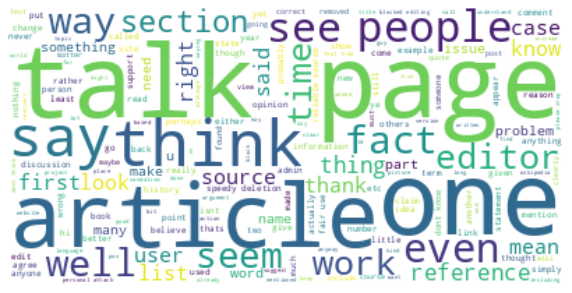

In [24]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# text_lt = " ".join(t for t in df["less_toxic"])

text_lt = " ".join(t for t in df_lt['text'])
print ("There are {} words in the combination of all less_toxic reviews.".format(len(text_lt)))

#Generate a word cloud image
wordcloud = WordCloud(stopwords=STOPWORDS,background_color="white").generate(text_lt)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [25]:
df_mt=df_train_binary.loc[df_train_binary['y']==1]
df_mt.head()

,text,y
6,cocksucker piss around work,1
12,hey talk exclusive group wp talibanswho good d...,1
16,bye dont look come think comming back tosser,1
42,gay antisemmitian archangel white tiger meow g...,1
43,fuck filthy mother ass dry,1


There are 3176069 words in the combination of all more_toxic reviews.


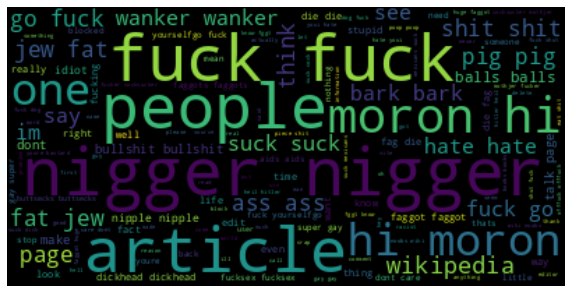

In [26]:
text_mt = " ".join(t for t in df_mt['text'])
print ("There are {} words in the combination of all more_toxic reviews.".format(len(text_mt)))

#Generate a word cloud image
wordcloud = WordCloud(stopwords=STOPWORDS,background_color="black").generate(text_mt)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Unbalanced dataset**

In [27]:
df_train_binary['y'].value_counts(normalize=True)

0    0.898321
1    0.101679
Name: y, dtype: float64

In [28]:
toxic_len = (df_train_binary['y'] == 1).sum()
print(toxic_len)

16225


In [29]:
df_train_balanced = df_train_binary[df_train_binary['y'] == 0].sample(n=toxic_len)
df_train_balanced['y'].value_counts(normalize=True)

0    1.0
Name: y, dtype: float64

**Balanced dataset**

In [30]:
df_train_b = pd.concat([df_train_binary[df_train_binary['y'] == 1], df_train_balanced])
df_train_b['y'].value_counts()

1    16225
0    16225
Name: y, dtype: int64

**TF-IDF**

In [31]:
# vec = TfidfVectorizer()

In [32]:
# X = vec.fit_transform(df_train_b['text'])
# X

In [33]:
# from sklearn.naive_bayes import MultinomialNB
# model = MultinomialNB()
# model.fit(X, df_train_b['y'])

In [34]:
# df_val = pd.read_csv("../input/jigsaw-toxic-severity-rating/validation_data.csv")
# df_val.head()

In [35]:
# unrelevant_words = ['wiki','wikipedia','page']
# #Clean step 1, 2 and 3
# df_val['less_toxic'] = df_val['less_toxic'].apply(lambda x: ''.join([w for w in clean_text(x) if w not in unrelevant_words]))

# #Clean Step 4
# df_val['less_toxic'] = df_val['less_toxic'].apply(lambda x: ''.join([w for w in stopwords(x,stop_words)]))

# #Clean Step 5
# df_val['less_toxic'] = df_val['less_toxic'].apply(lambda x: ''.join([w for w in lemmatizer.lemmatize(x)]))

# df_val.head()

In [36]:
# df_val['more_toxic'] = df_val['more_toxic'].apply(lambda x: ''.join([w for w in clean_text(x) if w not in unrelevant_words]))

# #Clean Step 4
# df_val['more_toxic'] = df_val['more_toxic'].apply(lambda x: ''.join([w for w in stopwords(x,stop_words)]))

# #Clean Step 5
# df_val['more_toxic'] = df_val['more_toxic'].apply(lambda x: ''.join([w for w in lemmatizer.lemmatize(x)]))

# df_val.head()

In [37]:
# X_less_toxic = vec.transform(df_val['less_toxic'])
# X_more_toxic = vec.transform(df_val['more_toxic'])

In [38]:
# p1 = model.predict_proba(X_less_toxic)
# p2 = model.predict_proba(X_more_toxic)

In [39]:
# (p1[:, 1] < p2[:, 1]).mean()

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df_train_b['text']).toarray()
labels = df_train_b['y']
features.shape

(32450, 22504)

In [41]:
# features_less_toxic = (df_val['less_toxic'])
# tfidf.transform(features_less_toxic).toarray()
# X_val_less_toxic =tfidf.fit_transform(features_less_toxic).toarray()
# # features_more_toxic = tfidf.fit_transform(df_val['more_toxic']).toarray()
# X_val_less_toxic.shape

In [42]:
# from io import StringIO
# col = ['y', 'text']
# df = df_train_binary[col]
# df = df[pd.notnull(df['text'])]
# df.columns = ['y', 'text']
# df['category_id'] = df['y'] .factorize()[0]
# category_id_df = df[['y', 'category_id']].drop_duplicates().sort_values('category_id')
# category_to_id = dict(category_id_df.values)
# id_to_category = dict(category_id_df[['category_id', 'y']].values)
# df.head()


In [43]:
# from sklearn.feature_selection import chi2
# import numpy as np
# N = 2
# for y,category_id in sorted(category_to_id.items()):
#   features_chi2 = chi2(features, labels == category_id)
#   indices = np.argsort(features_chi2[0])
#   feature_names = np.array(tfidf.get_feature_names())[indices]
#   unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#   bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#   print("# '{}':".format(y))
#   print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
#   print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

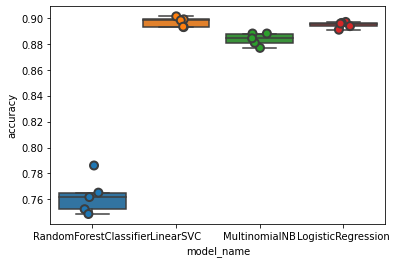

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [45]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.896888
LogisticRegression        0.894669
MultinomialNB             0.883575
RandomForestClassifier    0.762835
Name: accuracy, dtype: float64

In [46]:

# features_less_toxic = tfidf.transform(df_val['less_toxic'])
# features_less_toxic =features_less_toxic.fit_transform(president)


In [47]:

from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

svm = LinearSVC()
clf = CalibratedClassifierCV(svm) 
clf.fit(features, labels)




CalibratedClassifierCV(base_estimator=LinearSVC())

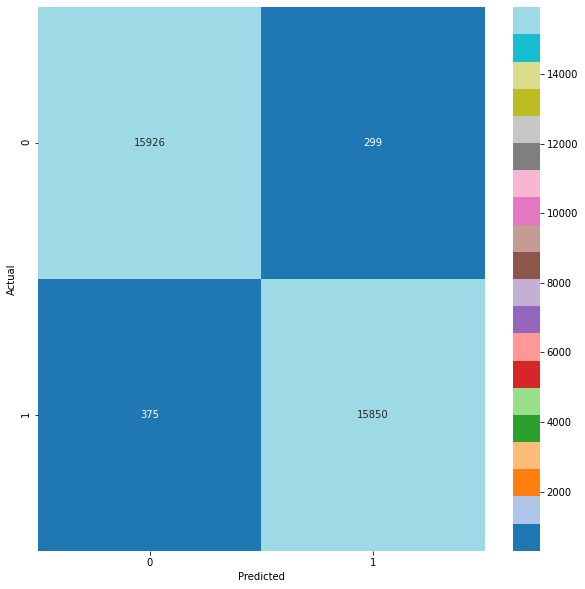

In [48]:
import seaborn as sns
y_pred = clf.predict(features)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(labels, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
cmap = "tab20"
sns.heatmap(conf_mat, annot=True, fmt='d',cmap=cmap)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [49]:
df_test = pd.read_csv('../input/jigsaw-toxic-severity-rating/comments_to_score.csv')
df_test.head()

,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."
2,1139051,I confess to having complete (and apparently b...
3,1434512,"""\n\nFreud's ideas are certainly much discusse..."
4,2084821,It is not just you. This is a laundry list of ...


In [50]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7537 entries, 0 to 7536
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   comment_id  7537 non-null   int64 
 1   text        7537 non-null   object
dtypes: int64(1), object(1)
memory usage: 117.9+ KB


In [51]:
X_test = df_test['text']
X_test.head()

0    "\n \n\nGjalexei, you asked about whether ther...
1    Looks like be have an abuser , can you please ...
2    I confess to having complete (and apparently b...
3    "\n\nFreud's ideas are certainly much discusse...
4    It is not just you. This is a laundry list of ...
Name: text, dtype: object

In [52]:
# X_test= tfidf.fit_transform(df_test['text']).toarray()
X_test= tfidf.transform(df_test['text'])
X_test.shape

(7537, 22504)

In [53]:
# svm = LinearSVC()
# clf = CalibratedClassifierCV(svm) 
# clf.fit(features, labels)
y_test = clf.predict_proba(X_test)
len(y_test)

7537

In [54]:
df_test['score'] = y_test[:, 1]
df_test['score'].head()

0    0.018340
1    0.113899
2    0.040302
3    0.279777
4    0.984847
Name: score, dtype: float64

In [55]:
df_test.head()

,comment_id,text,score
0,114890,"""\n \n\nGjalexei, you asked about whether ther...",0.018340
1,732895,"Looks like be have an abuser , can you please ...",0.113899
2,1139051,I confess to having complete (and apparently b...,0.040302
3,1434512,"""\n\nFreud's ideas are certainly much discusse...",0.279777
4,2084821,It is not just you. This is a laundry list of ...,0.984847


In [56]:
df_test[['comment_id', 'score']].to_csv("submission.csv", index=False)

In [57]:
# model = LogisticRegression(random_state=0)
# # X_train, y_train = train_test_split(features, labels)
# model.fit(features, labels)
# y_pred = model.predict(X_test)
# len(y_pred)